We begin by importing the relevant libraries. Please make sure that PyCWT is properly installed in your system.


In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot

import pycwt as wavelet
from pycwt.helpers import find

 Then, we load the dataset and define some data related parameters. In this
 case, the first 19 lines of the data file contain meta-data, that we ignore,
 since we set them manually (*i.e.* title, units).

In [2]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch
    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)
    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration
    return date.year + fraction

In [3]:
%load_ext autoreload
%autoreload 2

from pygeodyn.pygeodyn_plot_scalingfactors import *
import os
import pandas as pd
from netCDF4 import Dataset
def read_nc_file( filename, variables):
    ''' This function reads the TIEGCM .nc files and saves the given input variables to a dictionary.
        The breakloop feature is here so that if the file doesn't exist the code can still continue.  '''
    status = os.path.exists(filename)
    
    if status == True:
        data = {}
        for i, var_names in enumerate(variables):
            ncid =  Dataset(filename,"r+", format="NETCDF4")# filename must be a string
            varData = ncid.variables
            data[var_names] = np.array(varData[var_names])  
    elif status == False:
        print('No File Found', filename )
        breakloop = True
        data = 0
        return( data , breakloop)
    breakloop = False
    return(data,breakloop )


arc_list = []

arc_list_18 = np.arange(274,365)
for i in arc_list_18:
    val = '2018'+str(i)
    arc_list.append(int(val))
    
    #     print(val)
    
arc_list_19 = np.arange(1,112)
for i in arc_list_19:
    val = f"2019{i:03d}"
    arc_list.append(int(val))


path_to_f107 = '/data/SatDragModelValidation/data/inputs/atmos_models/geo_phys_indicies/gpi_1960001-2021243_f107aDaily.nc'

f107_data = read_nc_file(path_to_f107, ['year_day', 'f107d', 'f107a', 'kp'])


date = []
kp_list = []
f107d_list = []
f107a_list  = []
date_3hr = []
doy_list    = []



for i,val in enumerate(arc_list):
    
    index = f107_data[0]['year_day']==val
    kp_list.append(f107_data[0]['kp'][index][0])
    f107d_list.append(f107_data[0]['f107d'][index][0])
    f107a_list.append(f107_data[0]['f107a'][index][0])
    doy_list.append(str(f107_data[0]['year_day'][index][0])[-3:])

    date.append(pd.to_datetime( str(val), format='%Y%j'))

    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=0))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=3))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=6))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=9))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=12))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=15))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=18))
    date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=21))
#     date_3hr.append(pd.to_datetime( str(val), format='%Y%j') +pd.Timedelta(hours=24))
    
kp_expand = []
for i in kp_list:
    for ii in i:
        kp_expand.append(ii)
        
        
        
solar_fluxes = {}
solar_fluxes['f107d_list'] = f107d_list
solar_fluxes['f107a_list'] = f107a_list
solar_fluxes['date']       = date
solar_fluxes['date_3hr']   = date_3hr
solar_fluxes['kp_expand']  = kp_expand

f107d_earth = []
f107a_earth = []
######################################################################### 
##### Account for the F10.7 at earth (instead of referenced at 1AU) #####
######################################################################### 

for i_doy,val_doy in enumerate(doy_list):
    iday = int(val_doy)
    theta0 = 2 * np.pi * (iday)/365.
    sfeps = 1.000110 + 0.034221*np.cos(theta0)+0.001280* np.sin(theta0) +0.000719*np.cos(2.*theta0)+0.000077*np.sin(2.*theta0)

    f107d_earth.append(sfeps * solar_fluxes['f107d_list'][i_doy])
    f107a_earth.append(sfeps * solar_fluxes['f107a_list'][i_doy])

solar_fluxes['f107d_earth'] = f107d_earth
solar_fluxes['f107a_earth'] = f107a_earth

 
del f107d_earth
del f107a_earth
del kp_expand
del f107d_list
del f107a_list
del date
del date_3hr
del f107_data





In [4]:
import pandas as pd
from pygeodyn.pygeodyn_plot_scalingfactors import orbit_avg_generic

# gfo_file = 'gfo_6month.csv'
# gfo_df = pd.read_csv(gfo_file, sep = ',',)

# (timeavg_gfo,  denavg_gfo) = orbit_avg_generic(gfo_df['Date'], gfo_df['D500_gfo'], gfo_df['lat']) 
# denavg_gfo = denavg_gfo[:-1]
# del gfo_df

# y_signal =  
# N        = len(y_signal)
# unixtimes = pd.Series([ pd.Timestamp(date)  for date in solar_fluxes['date_3hr'] ])
# tim_unix =  [ ts.value/10**9  for ts in unixtimes ]
# x_time = tim_unix
T = 3   # hours

####--------------------------
dat   = np.asarray(solar_fluxes['kp_expand'])
title = 'Geomagnetic Flux'
label = 'Kp'
units = ''

# We also create a time array in years.
N = dat.size
t = np.asarray([ toYearFraction(pd.to_datetime(ts))  for ts in solar_fluxes['date_3hr'] ])
dt = np.diff(t).mean()
t0 = t[0]


# avg1, avg2 = (40000, 400000)                  # Range of periods to average
# avg1, avg2 = (0.00105436, 0.01125923)                  # Range of periods to average
# avg1, avg2 = (1.72803030e+07, 2.80698689e+09)                  # Range of periods to average
# 1.72803030e+07
# 2.80698689e+09


In [5]:
print(dt*356*24)

2.940521650620627


In [6]:
# url = 'http://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
# dat = np.genfromtxt(url, skip_header=19)
# title = 'NINO3 Sea Surface Temperature'
# label = 'NINO3 SST'
# units = 'degC'
# t0 = 1871.0
# dt = 0.25  # In years

# # We also create a time array in years.
# N = dat.size
# t = np.arange(0, N) * dt + t0


# avg1, avg2 = (2, 3)                  # Range of periods to average


Text(0, 0.5, 'Kp []')

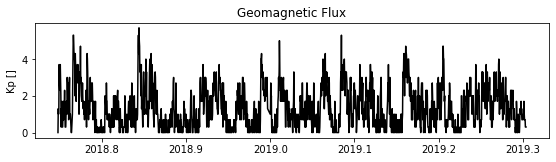

In [7]:
import matplotlib.pyplot as plt

figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('{}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

We write the following code to detrend and normalize the input data by its standard deviation. 
Sometimes detrending is not necessary and simply removing the mean value is good enough. 
Here, we fit a one-degree polynomial function and then subtract it from the original data.
However, if your dataset has a well defined trend, such as the Mauna Loa ${CO}_2$ dataset available in the
above mentioned website, it is strongly advised to perform detrending.


In [8]:
# p = np.polyfit(t - t0, dat, 1)
# dat_notrend = dat - np.polyval(p, t - t0)
# std = dat_notrend.std()  # Standard deviation
# var = std ** 2  # Variance
# dat_norm = dat_notrend / std  # Normalized dataset


In [9]:
# fig, ax1 = plt.subplots()

# color = 'tab:green'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('Detrended Data', color=color)
# ax1.plot(t, dat_norm , color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# color = 'tab:blue'
# ax2.set_ylabel('Original', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, dat, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

The next step is to define some parameters of our wavelet analysis. We
select the mother wavelet, in this case the Morlet wavelet with $\omega_0=6$.


In [10]:
# mother = wavelet.Morlet(6)
# s0 = 2 * dt                     # Starting scale, in this case 2 * 1.5 hours = 3 hours
# # s0 = 0.5 * dt                     # Starting scale, in this case 2 * 1.5 hours = 3 hours
# dj = 1 / 12                     # Twelve sub-octaves per octaves
# J = 7 / dj                      # Seven powers of two with dj sub-octaves
# alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise


The following routines perform the wavelet transform and inverse wavelet
transform using the parameters defined above. Since we have normalized our
input time-series, we multiply the inverse transform by the standard
deviation.


In [11]:
# wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,mother)

# iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std


We calculate the normalized wavelet and Fourier power spectra, as well as the Fourier equivalent periods for each wavelet scale.


In [12]:
# power = (np.abs(wave)) ** 2
# fft_power = np.abs(fft) ** 2
# period = (1 / freqs)
# print(period)      

Optionally, we could also rectify the power spectrum according to the suggestions proposed by Liu et al. (2007)[2]


In [13]:
# power /= scales[:, None]


 We could stop at this point and plot our results. However we are also interested in the power spectra significance test. The power is significant where the ratio ``power / sig95 > 1``.


In [14]:
# signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
#                                          significance_level=0.95,
#                                          wavelet=mother)
# sig95 = np.ones([1, N]) * signif[:, None]
# sig95 = power / sig95


Then, we calculate the global wavelet spectrum and determine its significance level.


In [15]:
# glbl_power = power.mean(axis=1)
# dof = N - scales  # Correction for padding at edges
# glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
#                                         significance_level=0.95, dof=dof,
#                                         wavelet=mother)

We also calculate the scale average between 2 years and 8 years, and its significance level.


In [16]:

# sel = find((period >= avg1) & (period < avg2))
# Cdelta = mother.cdelta
# scale_avg = (scales * np.ones((N, 1))).transpose()
# scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
# scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
# scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
#                                              significance_level=0.95,
#                                              dof=[scales[sel[0]],
#                                                   scales[sel[-1]]],
#                                              wavelet=mother)

Finally, we plot our results in four different subplots containing the
(i) original series anomaly and the inverse wavelet transform; (ii) the
wavelet power spectrum (iii) the global wavelet and Fourier spectra ; and
(iv) the range averaged wavelet spectrum. In all sub-plots the significance
levels are either included as dotted lines or as filled contour lines.


In [38]:
y=dat

y = (y-y.mean())/y.std()
std2 = y.std()**2

N = len(y)
lag1 = 0.
dj = 1/32
# avg1, avg2 = (3.60849252e-04, 5.95091692e-01)                  # Range of periods to average
# avg1, avg2 = (1.72803030e+07, 2.80698689e+09)                  # Range of periods to average

slevel = 0.95                        # Significance level

alpha, _, _ = wavelet.ar1(y)      # Lag-1 autocorrelation for red noise
alpha = 0.
mother = wavelet.Morlet(6)           # Morlet mother wavelet with m=6

# The following routines perform the wavelet transform and siginificance
# analysis for the chosen data set.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(y, dt, dj=dj, wavelet=mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother)

# Normalized wavelet and Fourier power spectra
power = (np.abs(wave)) ** 2 / scales[:, np.newaxis]
fft_power = np.abs(fft) ** 2
period = 1/ freqs
# print(period*365)
avg1, avg2 = (4/365, 16/365)                  # Range of periods to average


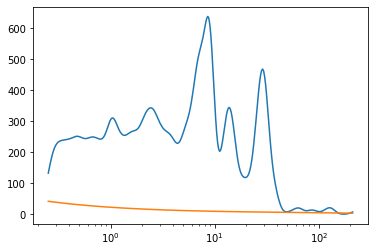

In [41]:
# Significance test. Where ratio power/sig95 > 1, power is significant.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                        significance_level=slevel, wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

### Power rectification as of Liu et al. (2007). TODO: confirm if significance
### test ratio should be calculated first.
### power /= scales[:, None]

# Calculates the global wavelet spectrum and determines its significance level.
glbl_power = power.mean(axis=1)
dof = N - scales                     # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                       significance_level=slevel, dof=dof, wavelet=mother)

### Scale average between avg1 and avg2 periods and significance level
# sel = wavelet.helpers.find((period >= avg1) & (period < avg2))
# Cdelta = mother.cdelta
# scale_avg = (scales * np.ones((N, 1))).transpose()

# ### As in Torrence and Compo (1998) equation 24
# scale_avg = power / scale_avg
# scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
# scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
#                             significance_level=slevel, dof=[scales[sel[0]],
#                             scales[sel[-1]]], wavelet=mother)


plt.semilogx(period*365, glbl_power)
plt.semilogx(period*365, glbl_signif/np.sqrt(scales))

<ipython-input-43-3b4010b892ec>:47: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, -12.0, '0.000244140625'),
 Text(0, -10.0, '0.0009765625'),
 Text(0, -8.0, '0.00390625'),
 Text(0, -6.0, '0.015625'),
 Text(0, -4.0, '0.0625'),
 Text(0, -2.0, '0.25'),
 Text(0, 0.0, '1.0')]

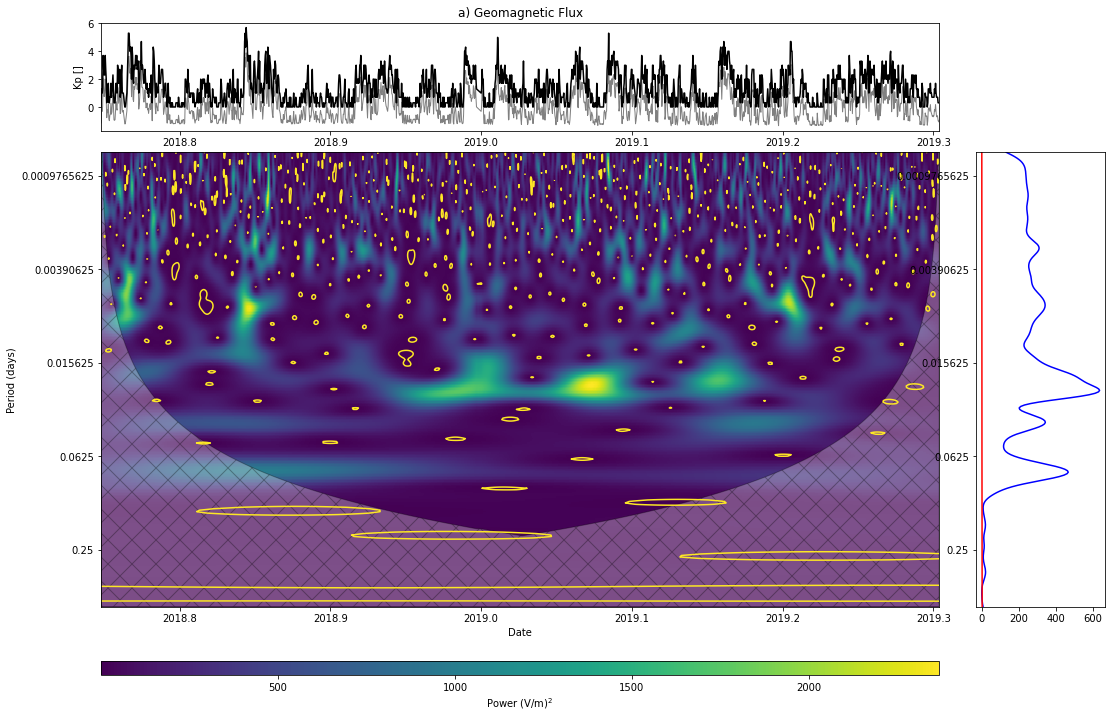

In [43]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(18,12) )

real_period = np.log2(period)
real_coi = np.log2(coi)
# real_period = period*365
# real_coi = coi*365

im = ax.pcolormesh(t, real_period, power, cmap='viridis')
ax.contour(t, real_period, sig95, [-99, 1])
# Hatch the coi where values don't make sense
ax.fill_between(t, real_coi, real_period.max(), color="white", alpha=0.3, hatch="x", edgecolor="k")

divider = make_axes_locatable(ax)
ax1 = divider.append_axes("top", size=1.5, pad=0.3, sharex=ax)
ax2 = divider.append_axes("right", size=1.8, pad=0.51, sharey=ax)
ax3 = divider.append_axes("bottom", size=0.2, pad=0.75)

#-------------------------------------------------------------------------------------
# First sub-plot, the original time series anomaly and inverse wavelet transform.
ax1.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax1.plot(t, dat, 'k', linewidth=1.5)
ax1.set_title('a) {}'.format(title))
ax1.set_ylabel(r'{} [{}]'.format(label, units))


#-------------------------------------------------------------------------------------


cbar = plt.colorbar(im, cax = ax3, orientation='horizontal')
# cbar.set_ticks([-200, -150, 0, 150, 200])
cbar.set_label(r"Power (V/m)$^2$")

ax2.plot(glbl_power, real_period, c='b')
ax2.plot(glbl_signif, real_period, c='r')


# ax2.yaxis.set_visible(False)

ax.set_xlabel("Date")
ax.set_ylabel("Period (days)")
ax.set_xlim(t.min(), t.max())
ax.set_ylim(real_period.max(), real_period.min())

# Change the ticks to the real values, rather than log2 based
ax.set_yticklabels([2**x for x in ax.get_yticks()])

# fig.suptitle("Wavelet Analysis of Neutral Den")

In [24]:
# # Prepare the figure
# pyplot.close('all')
# pyplot.ioff()
# figprops = dict(figsize=(11, 8), dpi=72)
# fig = pyplot.figure(**figprops)

# #-------------------------------------------------------------------------------------
# # First sub-plot, the original time series anomaly and inverse wavelet
# # transform.
# ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
# ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
# ax.plot(t, dat, 'k', linewidth=1.5)
# ax.set_title('a) {}'.format(title))
# ax.set_ylabel(r'{} [{}]'.format(label, units))


# #-------------------------------------------------------------------------------------
# # Second sub-plot, the normalized wavelet power spectrum and significance
# # level contour lines and cone of influece hatched area. 
# ## Note that period scale is logarithmic.

# bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
# levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
# bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
#             extend='both', cmap=pyplot.cm.viridis)
# extent = [t.min(), t.max(), 0, max(period)]
# bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#            extent=extent)
# bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
#                            t[:1] - dt, t[:1] - dt]),
#         np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
#                            np.log2(period[-1:]), [1e-9]]),
#         'k', alpha=0.3, hatch='x')
# bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
# bx.set_ylabel('Period (years)')
# #
# Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
#                            np.ceil(np.log2(period.max())))
# bx.set_yticks(np.log2(Yticks))
# bx.set_yticklabels(Yticks)


# #-------------------------------------------------------------------------------------
# # Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# # noise spectra. Note that period scale is logarithmic.
# cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
# cx.plot(glbl_signif, np.log2(period), 'k--')
# cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
# cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
#         linewidth=1.)
# cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
# cx.set_title('c) Global Wavelet Spectrum')
# cx.set_xlabel(r'Power [({})^2]'.format(units))
# cx.set_xlim([0, glbl_power.max() + var])
# cx.set_ylim(np.log2([period.min(), period.max()]))
# cx.set_yticks(np.log2(Yticks))
# cx.set_yticklabels(Yticks)
# pyplot.setp(cx.get_yticklabels(), visible=False)


# #-------------------------------------------------------------------------------------
# # Fourth sub-plot, the scale averaged wavelet spectrum.
# dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
# dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
# dx.plot(t, scale_avg, 'k-', linewidth=1.5)
# dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
# dx.set_xlabel('Time (year)')
# dx.set_ylabel(r'Average variance [{}]'.format(units))
# ax.set_xlim([t.min(), t.max()])

# pyplot.show()

In [ ]:
import sys
sys.exit()

# scrap

In [ ]:
# !pip install pycwt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import pycwt as wavelet

In [ ]:
t = np.linspace(0, 10*np.pi, 1000)
dt = t[-1]/len(t)
period1, period2, period3 = 0.2, 0.5, 2
y = 2*np.sin(2*np.pi/period1*t) + 2*np.sin(2*np.pi/period2*t) + 2*np.sin(2*np.pi/period3*t)
plt.plot(t, y)
print(y.mean(), y.std())

In [ ]:
print('dt',dt)

In [ ]:
1/32

In [ ]:
y = (y-y.mean())/y.std()
std2 = y.std()**2

N = len(y)
lag1 = 0.
dj = 1/32                            # Spacing between discrete scales. 
avg1, avg2 = (2, 8)                  # Range of periods to average
slevel = 0.95                        # Significance level

alpha, _, _ = wavelet.ar1(y)         # Lag-1 autocorrelation for red noise
alpha = 0.
mother = wavelet.Morlet(6)           # Morlet mother wavelet with m=6

# The following routines perform the wavelet transform and siginificance
# analysis for the chosen data set.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(y, dt, dj=dj, wavelet=mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother)

# Normalized wavelet and Fourier power spectra
power = (np.abs(wave)) ** 2 / scales[:, np.newaxis]
fft_power = np.abs(fft) ** 2
period = 1/ freqs

# Significance test. Where ratio power/sig95 > 1, power is significant.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                        significance_level=slevel, wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Power rectification as of Liu et al. (2007). TODO: confirm if significance 
# test ratio should be calculated first.
#power /= scales[:, None]

# Calculates the global wavelet spectrum and determines its significance level.
glbl_power = power.mean(axis=1)
dof = N - scales                     # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(std2, dt, scales, 1, alpha,
                       significance_level=slevel, dof=dof, wavelet=mother)

# Scale average between avg1 and avg2 periods and significance level
sel = wavelet.helpers.find((period >= avg1) & (period < avg2))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
# As in Torrence and Compo (1998) equation 24
scale_avg = power / scale_avg
scale_avg = std2 * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(std2, dt, scales, 2, alpha,
                            significance_level=slevel, dof=[scales[sel[0]],
                            scales[sel[-1]]], wavelet=mother)


In [ ]:
plt.semilogx(period, glbl_power)
plt.semilogx(period, glbl_signif/np.sqrt(scales))

In [ ]:
fig, ax = plt.subplots(figsize=(20,12) )

real_period = np.log2(period)
real_coi = np.log2(coi)

im = ax.pcolormesh(t, real_period, power, cmap='viridis')

ax.contour(t, real_period, sig95, [-99, 1])
# Hatch the coi where values don't make sense
ax.fill_between(t, real_coi, real_period.max(), color="k", alpha=0.4, hatch="x", edgecolor="k")

divider = make_axes_locatable(ax)
#ax1 = divider.append_axes("top", size=1.5, pad=0.1, sharex=ax)
ax2 = divider.append_axes("right", size=1.5, pad=0.1, sharey=ax)
ax3 = divider.append_axes("bottom", size=0.2, pad=0.75)

cbar = plt.colorbar(im, cax = ax3, orientation='horizontal')
#cbar.set_ticks([-200, -150, 0, 150, 200])
cbar.set_label(r"Power (V/m)$^2$")

ax2.plot(glbl_power, real_period, c='b')
ax2.plot(glbl_signif, real_period, c='r')


ax2.yaxis.set_visible(False)

ax.set_xlabel("Time (days)")
ax.set_ylabel("Period (days)")
ax.set_xlim(t.min(), t.max())
ax.set_ylim(real_period.max(), real_period.min())

# Change the ticks to the real values, rather than log2 based
ax.set_yticklabels([2**x for x in ax.get_yticks()])

fig.suptitle("Wavelet Analysis of Electric Field")